## Process convex surfaces from planeseg library.

In [1]:
#!/usr/bin/env python3
#
# Copyright 2022 University of Edinburgh
# All rights reserved.
#
# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions are met:
#
#  * Redistributions of source code must retain the above copyright notice,
#    this list of conditions and the following disclaimer.
#  * Redistributions in binary form must reproduce the above copyright
#    notice, this list of conditions and the following disclaimer in the
#    documentation and/or other materials provided with the distribution.
#  * Neither the name of  nor the names of its contributors may be used to
#    endorse or promote products derived from this software without specific
#    prior written permission.
#
# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
# AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
# IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE
# ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT OWNER OR CONTRIBUTORS BE
# LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR
# CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF
# SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS
# INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN
# CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE)
# ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE
# POSSIBILITY OF SUCH DAMAGE.

import numpy as np
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import walkgen_surface_processing
from walkgen_surface_processing.tools.geometry_utils import convert_from_marker_array, reduce_surfaces, order,process_surfaces
from walkgen_surface_processing.tools.plot_tools import plot_marker_surface, plot_surface

# Load Planeseg data, MarkerArray class example extracted from rosbag.
path = walkgen_surface_processing.__path__[0] + "/data/"
try:
    filename = path + "example_marker_array.pickle"
    with open(filename, 'rb') as file2:
        array_markers = pickle.load(file2)
except ValueError:
    # Python2.7
    filename = path + "example_marker_array_prot2.pickle"
    with open(filename, 'rb') as file2:
        array_markers = pickle.load(file2)
    
# Plot 3D
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection='3d')
plot_marker_surface(array_markers, ax )

### Compare different methods to reduce the number of points

In [7]:
# Compare different methods to reduce the number of points
from rdp import rdp,rdp_iter, rdp_rec
import visvalingamwyatt as vw
# Initial list
points_ = array_markers.markers[0].points
pts = [[points_[2*k].x, points_[2*k].y,points_[2*k].z] for k in range(int((len(points_)-1 )/ 2))]
pts.append([points_[-1].x, points_[-1].y, points_[-1].z])

# RDP Algo
pts_rdp = rdp(pts, epsilon=0.05) # Cannot tune the final number of points
# VW Algo
simplifier = vw.Simplifier(pts)
pts_vw = simplifier.simplify(number=6).tolist()

# Vizualisation purpose
pts.append([points_[0].x, points_[0].y, points_[0].z]) 
pts_rdp.append(pts_rdp[0])
pts_vw.append(pts_vw[0])

# Plot 3D
fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection='3d')

X = np.array(pts)[:,0]
Y = np.array(pts)[:,1]
Z = np.array(pts)[:,2]
X_r = np.array(pts_rdp)[:,0]
Y_r = np.array(pts_rdp)[:,1]
Z_r = np.array(pts_rdp)[:,2]
X_v = np.array(pts_vw)[:,0]
Y_v = np.array(pts_vw)[:,1]
Z_v = np.array(pts_vw)[:,2]

ax.plot3D(X,Y,Z, label='Initial surface, pts = ' + str(len(pts)-1))
ax.plot3D(X_r,Y_r,Z_r, label='RDP Surface , pts = ' + str(len(pts_rdp)-1),color ="y")
ax.plot3D(X_v,Y_v,Z_v, label='VW Surface , pts = ' + str(len(pts_vw)-1), color = "g")
ax.legend(loc="upper left")

ImportError: No module named rdp

### First step : Sort, remove duplicates and reduce the number of points

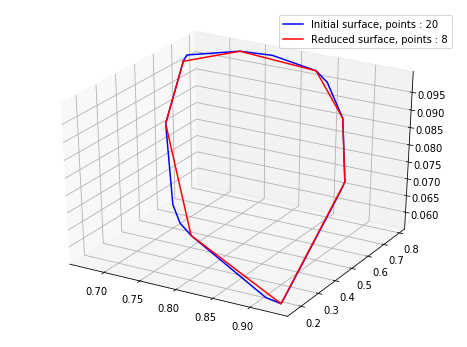

In [2]:
# Convert to list of vertices
surface_list = convert_from_marker_array(array_markers)

# Reduce the number of points
n_points = 8
i_surface = 2
surface_reduced = reduce_surfaces(surface_list, n_points)

# Plot 3D
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection='3d')
# order the initial surface only for plotting 
surface_init = order(np.array(surface_list[i_surface]))
plot_surface(np.array(surface_init), ax, color= "b", label = "Initial surface, points : " + str(len(surface_list[i_surface])))
plot_surface(surface_reduced[i_surface], ax, color = "r", label = "Reduced surface, points : " + str(len(surface_reduced[i_surface])))
ax.legend()

### Apply inner and outter margin

[ 0.6702618   0.68952888  0.09697371]
[[ 0.10943299  0.99340053  0.03434844]
 [-0.99185124  0.11139971 -0.06181604]
 [-0.06523449 -0.02730383  0.99749635]]
[ 0.6702618   0.68952888  0.09697371]
[[ 0.10943299  0.99340053  0.03434844]
 [-0.99185124  0.11139971 -0.06181604]
 [-0.06523449 -0.02730383  0.99749635]]


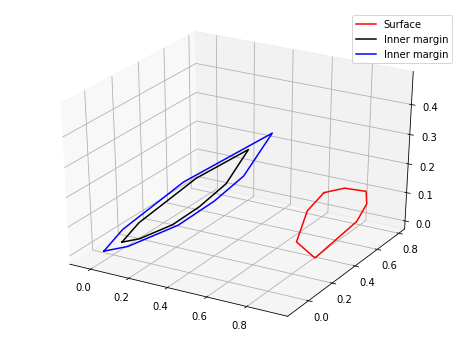

In [4]:
from walkgen_surface_processing.tools.SurfaceData import SurfaceData

# SurfaceData structure
i_surface = 2
margin_inner = 0.02
margin_outter = 0.02
surface = SurfaceData(surface_reduced[i_surface], margin_inner, margin_outter)

# Plot 3D
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection='3d')
# order the initial surface only for plotting 
plot_surface(surface_reduced[i_surface], ax, color = "r", label = "Surface")
plot_surface(surface.vertices_inner, ax, color = "k", label = "Inner margin")
plot_surface(surface.vertices_outer, ax, color = "b", label = "Inner margin")
ax.legend()

### Decompose the surfaces to avoid overlapping

In [10]:
_poly_size = 10
_method_id = 3
_min_area = 0.03
_margin_inner = 0.03
_margin_outer = 0.02
surfaces_processed = process_surfaces(
            surface_reduced,
            polySize=_poly_size,
            method=_method_id,
            min_area=_min_area,
            margin_inner=_margin_inner,
            margin_outer=_margin_outer)

# Plot 3D
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection='3d')
for sf in surfaces_processed:
    plot_surface(sf, ax)

AttributeError: 'list' object has no attribute 'clear'

### Details of the function

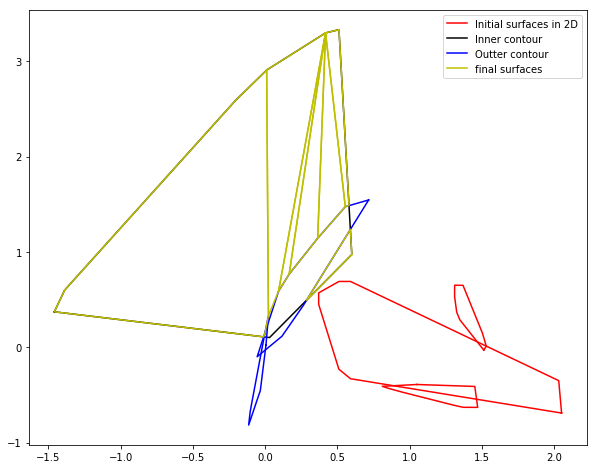

In [11]:
from walkgen_surface_processing.tools.geometry_utils import DECOMPO_type, tess,process_tess_results, projection_surface, get_contour, get_Polygon
from walkgen_surface_processing.tools.plot_tools import plot_surface2D, plot_contour
from enum import Enum

import visvalingamwyatt as vw
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon

from walkgen_surface_processing.tools.SurfaceData import SurfaceData
import walkgen_surface_processing.tools.Tess2 as Tess2
from pyhull import qconvex

method_type = method_type = DECOMPO_type(1)
margin_inner = 0.03
margin_outer = 0.02
polySize = 10
min_area = 0.03


surfaces = []
new_surfaces = []

for sf in surface_reduced:
#     try :
    s = SurfaceData(sf, margin_inner=margin_inner, margin_outer=margin_outer)
    surfaces.append(s)
#     except :
#         print("Applying inner margin not feasible. Surface removed.")

# Temporary list for decomposition.
contours_intersect = []
surfaces_intersect = []

# Run the list of surfaces starting with the lowest.
# while len(surfaces) > 1:
# contours_intersect.clear()
# surfaces_intersect.clear()

# h_mean = [sf.h_mean for sf in surfaces]
# id_ = np.argmin(h_mean)

id_ = 6

id_intersect = []

for i, s_ in enumerate(surfaces):
    if i != id_:
        if surfaces[id_].Polygon_inner.intersects(s_.Polygon_outer):
            surfaces_intersect.append(s_)
            contours_intersect.append(s_.contour_outer)
            id_intersect.append(i)

if method_type == DECOMPO_type.CONVEX or method_type == DECOMPO_type.AREA_CONVEX:
    # If only one surface, no need for the convex union
    if len(surfaces_intersect) > 1:
        contours_intersect.clear()  # Redefine the contour for the difference
        vertices_union = np.zeros((1, 2))
        for sf in surfaces_intersect:
            vertices_union = np.vstack(
                [vertices_union, sf.vertices_outer[:, :2]])
        convexHUll = ConvexHull(vertices_union[1:, :])
        vert_2D = np.zeros((2, 1))
        for j in convexHUll.vertices:
            vert_2D = np.hstack(
                [vert_2D, convexHUll.points[j, :].reshape((2, 1), order="F")])

        contours_intersect = [get_contour(vert_2D[:, 1:])]

# No surface overllaping, keep initial surface.
if len(contours_intersect) == 0:
    new_surfaces.append(surfaces[id_].vertices_inner)

# Surface overllaping, decompose the surface.
if len(contours_intersect) != 0:

    res = tess.difference([surfaces[id_].contour_inner],
                          contours_intersect, polySize=polySize)
    surface_processed = process_tess_results(res, polySize)

    if surface_processed is None:  # no surface left after intersection.
        surfaces[id_].vertices_reshaped = None
    else:
        for vt in surface_processed:

            if method_type == DECOMPO_type.AREA or method_type == DECOMPO_type.AREA_CONVEX:
                # Keep the surface if the area > min_area
                # Or if the surface has not been decomposed
                if get_Polygon(get_contour(vt)).area > min_area :
                    new_surfaces.append(projection_surface(vt, surfaces[id_].equation) )
            else:
                new_surfaces.append(projection_surface(vt, surfaces[id_].equation) )

# Remove the surface processed from the lists.
# surfaces.pop(id_)

# Add last surface remaining
# new_surfaces.append(surfaces[0].get_vertices_inner())

plt.figure(figsize=(10,8))
ax = plt.axes()
plot_surface2D(surfaces[id_].vertices.T, ax, color = "r", label = "Initial surfaces in 2D")
plot_contour(surfaces[id_].contour_inner, ax, color = "k", label = "Inner contour")

for ct in contours_intersect[:-1]:
    plot_contour(ct, ax, color = "b")

plot_contour(contours_intersect[-1], ax, color = "b", label = "Outter contour")

for elt in id_intersect:
    plot_surface2D(surfaces[elt].vertices.T, ax , color = "r")

for vt in new_surfaces[:-1]:
    plot_surface2D(vt.T, ax, color = "y")
    
plot_surface2D(new_surfaces[-1].T, ax, color = "y", label = "final surfaces")
    
ax.legend()

In [7]:
surfaces[id_].contour_inner

[0.6072356537965251,
 -0.303319361856236,
 2.0178423558056697,
 -0.6511493549663634,
 2.0012317562418276,
 -0.3660096772885842,
 0.580702400393873,
 0.6599633048277675,
 0.5215853968151825,
 0.659955232176199,
 0.4001588757668495,
 0.5561590403256105,
 0.4001510133505841,
 0.45303842797599625,
 0.5378255321182097,
 -0.216853731962036]